**<center><h1>Advanced Computer Vision for Artificial Intelligence Assignment</h1></center>**
**<center><h2>Part 3 - Object Detection Component (RetinaNet)</h2></center>**
**<center><h3>Matthias Bartolo, Jerome Agius, Isaac Muscat</h3></center>**

RetinaNet is a single-stage object detection model that uses a focal loss function to deal with class imbalance during training. Focal loss applies a modulation term to the cross-entropy loss to focus learning on hard negative examples. Retina-Net is a single unified network consisting of a major back network and two task-specific subnetworks. The backbone is accountable for computing a convolutional characteristic map over the whole input image and is an off-the-self convolutional network. The first subnet performs convolutional object classification on the backbone output; the second subnet performs convolutional bounds regression. These two subnets have a simple design that the authors propose specifically for one-step dense detection

## This Notebook is Structure in the following manner:

- Required libraries
- Downloading the Roboflow datset
- Training the RetineNet model
- Testing the RetinaNet model on the Testing subset
- Testing Results

**<h3>Libraries required to utilise GPU if one is available.</h3>**

<font size="0.1">

```python
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
python -m pip install "tensorflow<2.11"
# Verify the installation:
python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
```
</font>

Reference Link: https://www.tensorflow.org/install/pip#windows-native

**<h3>Required installs.</h3>**

In [1]:
# !pip install roboflow

In [2]:
# !pip install -r requirements.txt

In [3]:
# !pip install keras==2.15.0
# !pip install gast==0.2.2
# !pip install protobuf==3.17.3
# !pip install tensorboard==2.10.0
# !pip install tensorflow-estimator==2.10.0

In [4]:
# Download RetinaNet
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!python setup.py build_ext --inplace

c:\Users\User\Downloads\RetinaNet\keras-retinanet


fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


running build_ext


c:\Users\User\anaconda3\envs\retinanet\lib\site-packages\setuptools\__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)


In [5]:
# !pip install -r requirements.txt

In [6]:
# !pip install keras==2.6.0
# !pip install tensorflow==2.10.1
# !pip install keras-resnet

In [7]:
# !pip install tensorflow-gpu

**<h3>Replacing RetinaNet files with updated variants.</h3>**

In [8]:
evaluation_path = "../filesToReplace/modified_evaluate.py"
evaluation_copyTo_path = "keras_retinanet/bin/evaluate.py"

eval_path = "../filesToReplace/modified_eval.py"
eval_copyTo_path = "keras_retinanet/utils/eval.py"

visualise_path = "../filesToReplace/visualization.py"
visualise_copyTo_path= "keras_retinanet/utils/visualization.py"

def copy_and_replace(file_a, file_b):
    try:
        with open(file_a, 'r') as file_a_contents:
            data = file_a_contents.read()

        with open(file_b, 'w') as file_b_contents:
            file_b_contents.write(data)

        print(f"Contents of {file_a} copied and replaced in {file_b} successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

copy_and_replace(evaluation_path, evaluation_copyTo_path)
copy_and_replace(eval_path, eval_copyTo_path)


Contents of ../filesToReplace/modified_evaluate.py copied and replaced in keras_retinanet/bin/evaluate.py successfully.
Contents of ../filesToReplace/modified_eval.py copied and replaced in keras_retinanet/utils/eval.py successfully.


**<h3>Using GPU if one is available.</h3>**

In [9]:
import tensorflow as tf

tf.__version__

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    for gpu in gpus:
        print("Device name:", gpu.name)
else:
    print("No GPU available, using CPU instead")

GPU is available
Device name: /physical_device:GPU:0


In [10]:
%cd keras-retinanet/

[WinError 2] The system cannot find the file specified: 'keras-retinanet/'
c:\Users\User\Downloads\RetinaNet\keras-retinanet


**<h3>Required libraries.</h3>**

In [11]:
import os
import csv
import cv2
import time
import keras
import pandas
import shutil
import urllib
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from keras_retinanet import models
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

In [12]:
# Retrieving the current working directory
HOME = os.getcwd()
print(HOME)

c:\Users\User\Downloads\RetinaNet\keras-retinanet


**<h3>Downloading the Roboflow dataset.</h3>**

In [13]:
# Download Dataset
from roboflow import Roboflow
rf = Roboflow(api_key="y2FfMokLpTlGQIlMvhja")
project = rf.workspace("advanced-computer-vision-assignment").project("pizza-object-detector")
dataset = project.version(7).download("retinanet")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pizza-Object-Detector-7 in retinanet:: 100%|██████████| 3115/3115 [00:01<00:00, 2835.33it/s]


In [14]:
#Annotations and Classes csv path
annotations_path = os.path.join(HOME, os.path.join('Pizza-Object-Detector-7','train','_annotations.csv'))
classes_path     = os.path.join(HOME, os.path.join('_classes.csv'))

# Replace the annotations csv file with the new one
evaluation_path = "../filesToReplace/_annotations.csv"
evaluation_copyTo_path = os.path.join(HOME, os.path.join('Pizza-Object-Detector-7','train','_annotations.csv'))
copy_and_replace(evaluation_path, evaluation_copyTo_path)

!copy {annotations_path} {os.path.join(HOME, os.path.join('Pizza-Object-Detector-7','train','_annotations2.csv'))}
shutil.copy(annotations_path, os.path.join(HOME, os.path.join('Pizza-Object-Detector-7','train','_annotations2.csv')))
annotations_path_temp = os.path.join(HOME, os.path.join('Pizza-Object-Detector-7','train','_annotations2.csv'))

#Create Classes csv
with open(classes_path, 'w', newline='') as f:
    f.write('cranes,0')

classes = [
    'Arugula', 'Bacon', 'Basil', 'Broccoli', 'Cheese', 'Chicken', 'Corn', 'Ham',
    'Mushroom', 'Olives', 'Onion', 'Pepperoni', 'Peppers', 'Pineapple', 'Pizza', 'Tomatoes'
]

with open(classes_path, 'w', newline='') as f:
    csv_writer = csv.writer(f)
    for idx, class_name in enumerate(classes):
        csv_writer.writerow([class_name, idx])

with open(classes_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Read each row in the CSV file
        for row in reader:
            print(row)

#Remove Empty Lines in Annotations csv
!copy {annotations_path} {annotations_path_temp}
print(os.getcwd())
with open(annotations_path_temp, newline='') as in_file:
    with open(annotations_path, 'w', newline='') as out_file:
        writer = csv.writer(out_file)
        for row in csv.reader(in_file):
            if row:
                writer.writerow(row)

Contents of ../filesToReplace/_annotations.csv copied and replaced in c:\Users\User\Downloads\RetinaNet\keras-retinanet\Pizza-Object-Detector-7\train\_annotations.csv successfully.
        1 file(s) copied.
['Arugula', '0']
['Bacon', '1']
['Basil', '2']
['Broccoli', '3']
['Cheese', '4']
['Chicken', '5']
['Corn', '6']
['Ham', '7']
['Mushroom', '8']
['Olives', '9']
['Onion', '10']
['Pepperoni', '11']
['Peppers', '12']
['Pineapple', '13']
['Pizza', '14']
['Tomatoes', '15']


        1 file(s) copied.
c:\Users\User\Downloads\RetinaNet\keras-retinanet


**<h3>Downloading the pre-trained weights.</h3>**

In [15]:
# Download pre-trained weights
url = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
pretrained_model_path = os.path.join('snapshots','pretrained-model.h5')

urllib.request.urlretrieve(url, pretrained_model_path)

('snapshots\\pretrained-model.h5', <http.client.HTTPMessage at 0x1af3b0fb850>)

**<h3>Training the RetinaNet model.</h3>**

In [16]:
#ALTERNATIVE: Run command in terminal instead
print(f'python keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {pretrained_model_path} --batch-size 8 --steps 500 --epochs 50 csv {annotations_path} {classes_path}')

python keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights snapshots\pretrained-model.h5 --batch-size 8 --steps 500 --epochs 50 csv c:\Users\User\Downloads\RetinaNet\keras-retinanet\Pizza-Object-Detector-7\train\_annotations.csv c:\Users\User\Downloads\RetinaNet\keras-retinanet\_classes.csv


In [17]:
!python keras_retinanet/bin/train.py \
        --freeze-backbone --random-transform --weights {pretrained_model_path} \
         --batch-size 8 --steps 86 --epochs 100 --tensorboard-dir tensorboard csv {annotations_path} {classes_path}

Creating model, this may take a second...
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)             

2023-12-30 20:39:05.908752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 20:39:06.253832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
c:\Users\User\anaconda3\envs\retinanet\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  

**<h3>Carrying out Inference on the model.</h3>**

In [18]:
# For prediction (To properly visualize the bounding boxes)
visualise_path_1 = "../filesToReplace/modified_visualization.py"
visualise_copyTo_path= "keras_retinanet/utils/visualization.py"

copy_and_replace(visualise_path_1, visualise_copyTo_path)

Contents of ../filesToReplace/modified_visualization.py copied and replaced in keras_retinanet/utils/visualization.py successfully.


In [19]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

img_save_path = os.path.join(HOME, 'inference_images')

if not os.path.exists(img_save_path):
    os.makedirs(img_save_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(classes_path,header=None).T.loc[0].to_dict()


def img_inference(img_path, threshold):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("Processing Time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < threshold:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    height, width, _ = draw.shape  # Get the height and width of the image
    plt.figure(figsize=(width / 100, height / 100))  # Set the figure size based on the image size
    plt.axis('off')
    plt.imshow(draw)
    plt.savefig(os.path.join(img_save_path, os.path.basename(img_path) + ".jpg"), bbox_inches='tight')
    plt.close()
    # plt.show()

snapshots\resnet50_csv_99.h5


The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.


In [20]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

test_path = os.path.join('Pizza-Object-Detector-7','test')

images = [os.path.join(test_path,img) for img in os.listdir(test_path) if '.jpg' in img]

for img in images:
    img_inference(img, 0.5)

Processing Time:  2.7901651859283447
Processing Time:  1.3851959705352783
Processing Time:  0.2917187213897705
Processing Time:  0.3416762351989746
Processing Time:  0.28693628311157227
Processing Time:  0.0555117130279541
Processing Time:  0.05820798873901367
Processing Time:  0.3191666603088379
Processing Time:  0.04650735855102539
Processing Time:  0.04697275161743164
Processing Time:  0.3316824436187744
Processing Time:  0.25351738929748535
Processing Time:  0.05292630195617676
Processing Time:  0.0614163875579834
Processing Time:  0.051138877868652344
Processing Time:  0.04951333999633789
Processing Time:  0.25437116622924805
Processing Time:  0.0559992790222168
Processing Time:  0.05800127983093262
Processing Time:  0.29778289794921875
Processing Time:  0.0575871467590332
Processing Time:  0.07150936126708984
Processing Time:  0.04999971389770508
Processing Time:  0.050000667572021484
Processing Time:  0.0469970703125
Processing Time:  0.05235099792480469
Processing Time:  0.3355

**<h3>Testing the RetinaNet model on the Testing subset.</h3>**

In [21]:
test_annotations_path = os.path.join(HOME, os.path.join('Pizza-Object-Detector-7','test','_annotations.csv'))
model_path            = os.path.join(HOME, os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0]))
inference_model_path  = os.path.join(HOME, os.path.join('snapshots','inference_resnet50_csv.h5'))
save_path             = os.path.join(HOME, os.path.join('evaluation'))
classes_path          = os.path.join(HOME, os.path.join('_classes.csv'))

In [22]:
#ALTERNATIVE: Run commands in terminal instead
print(f'python keras_retinanet/bin/convert_model.py {model_path} {inference_model_path}')
print(f'python keras_retinanet/bin/evaluate.py csv {test_annotations_path} {classes_path} {inference_model_path}')

python keras_retinanet/bin/convert_model.py c:\Users\User\Downloads\RetinaNet\keras-retinanet\snapshots\resnet50_csv_99.h5 c:\Users\User\Downloads\RetinaNet\keras-retinanet\snapshots\inference_resnet50_csv.h5
python keras_retinanet/bin/evaluate.py csv c:\Users\User\Downloads\RetinaNet\keras-retinanet\Pizza-Object-Detector-7\test\_annotations.csv c:\Users\User\Downloads\RetinaNet\keras-retinanet\_classes.csv c:\Users\User\Downloads\RetinaNet\keras-retinanet\snapshots\inference_resnet50_csv.h5


In [23]:
#Convert training model to inference model
!python keras_retinanet/bin/convert_model.py {model_path} {inference_model_path}

# For cv::Mat error
visualise_path = "../filesToReplace/visualization.py"
visualise_copyTo_path= "keras_retinanet/utils/visualization.py"

copy_and_replace(visualise_path, visualise_copyTo_path)

#Evaluate
!python keras_retinanet/bin/evaluate.py --gpu 0 --score-threshold 0.0 --save-path {save_path} --no-resize\
        csv {test_annotations_path} {classes_path} {inference_model_path}

Contents of ../filesToReplace/visualization.py copied and replaced in keras_retinanet/utils/visualization.py successfully.


2023-12-30 23:04:04.983113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
c:\Users\User\anaconda3\envs\retinanet\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1 Physical GPUs, 1 Logical GPUs
Loading model, this may take a second...
209 instances of class Arugula with average precision: 0.0050
49 instances of class Bacon with average precision: 0.0000
492 instances of class Basil with average precision: 0.2318
31 instances of class Broccoli with average precision: 0.0538
620 instances of class Cheese with average precision: 0.0615
184 instances of class Chicken with average precision: 0.0002
184 instances of class Corn with average precision: 0.0000
277 instances of class Ham with average precision: 0.0066
456 instances of class Mushroom with average precision: 0.0273
580 instances of class Olives with average precision: 0.2463
204 instances of class Onion with average precision: 0.0000
849 instances of class Pepperoni with average precision: 0.4181
555 instances of class Peppers with average precision: 0.0474
98 instances of class Pineapple with average precision: 0.0000
313 instances of class Pizza with average precision: 0.9186
745 instanc

2023-12-30 23:04:08.981142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 23:04:09.368254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
c:\Users\User\anaconda3\envs\retinanet\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  

In [24]:
# Loading [average_precisions, inference_time, precision_recall] from numpy evaluation_results.npy file
evaluation_results = np.load(os.path.join(HOME, 'evaluation_results.npy'), allow_pickle=True)

average_precisions = evaluation_results[0]
inference_time     = evaluation_results[1]
precision_recall   = evaluation_results[2]

In [25]:
# average_precisions

In [26]:
# precision_recall

In [33]:
# Retrieving the average precisions for each class from the average_precisions dictionary first element in the average precisions dictionary items
aps = [average_precision[0] for label, average_precision in average_precisions.items()]

print('\033[35m' + 'Average Precisions for each class:' + '\033[0m')
for idx, ap in enumerate(aps):
    print(f'{classes[idx]:15}: {ap}')

# Mean Average Precision
mean_average_precision = np.mean(aps)
print(f'\n\033[37m' + 'Mean Average Precision (mAP):' + '\033[0m')
print(f'{mean_average_precision}')

Average Precisions for each class:
Arugula        : 0.005016673916195447
Bacon          : 0.0
Basil          : 0.23183565521104982
Broccoli       : 0.05376344086021505
Cheese         : 0.061468365656653756
Chicken        : 0.00018422991893883567
Corn           : 0.0
Ham            : 0.0065836776025293055
Mushroom       : 0.027279908060418075
Olives         : 0.2463227237639064
Onion          : 0.0
Pepperoni      : 0.41809744435160456
Peppers        : 0.047394101739777386
Pineapple      : 0.0
Pizza          : 0.9186188208854265
Tomatoes       : 0.14792537137538855

Mean Average Precision (mAP):
0.1352806508338815


**<h3>Testing Results.</h3>**

In [28]:
import os

# Construct the logdir path
logdir = os.path.join(HOME, 'tensorboard')

%load_ext tensorboard
%tensorboard --logdir={logdir}

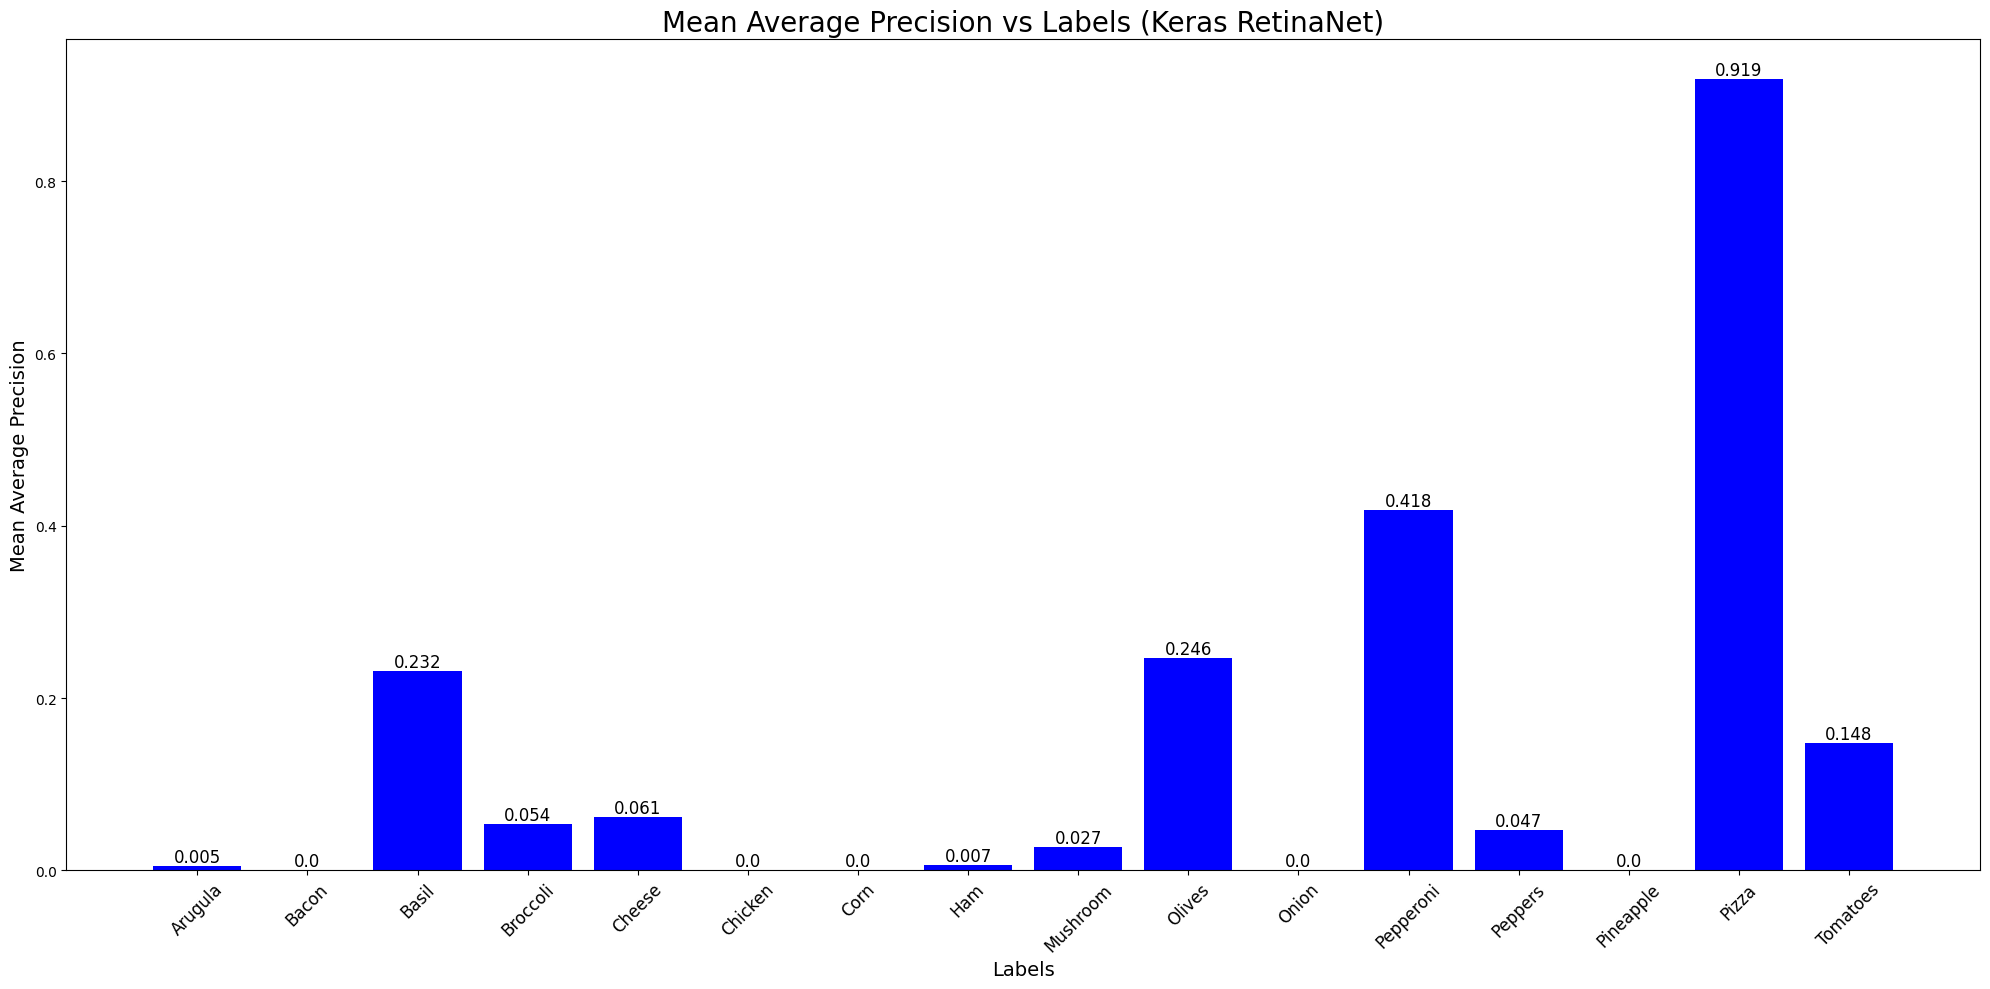

In [29]:
plt.figure(figsize=(20, 10))
plt.bar(list(average_precisions.keys()), list(aps), color='blue')

# Putting text on the bar chart
for idx, val in enumerate(aps):
    plt.text(idx, val, round(val, 3), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight': 500, 'size': 12})

# Set the x-ticks to correspond to all labels
plt.gca().set_xticks(range(len(classes)))

plt.xticks(rotation=45, fontsize=12)
# Set the labels to the actual class labels
plt.gca().set_xticklabels(classes)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Mean Average Precision", fontsize=14)
plt.title("Mean Average Precision vs Labels (Keras RetinaNet)", fontsize=20)
plt.tight_layout()
plt.show()

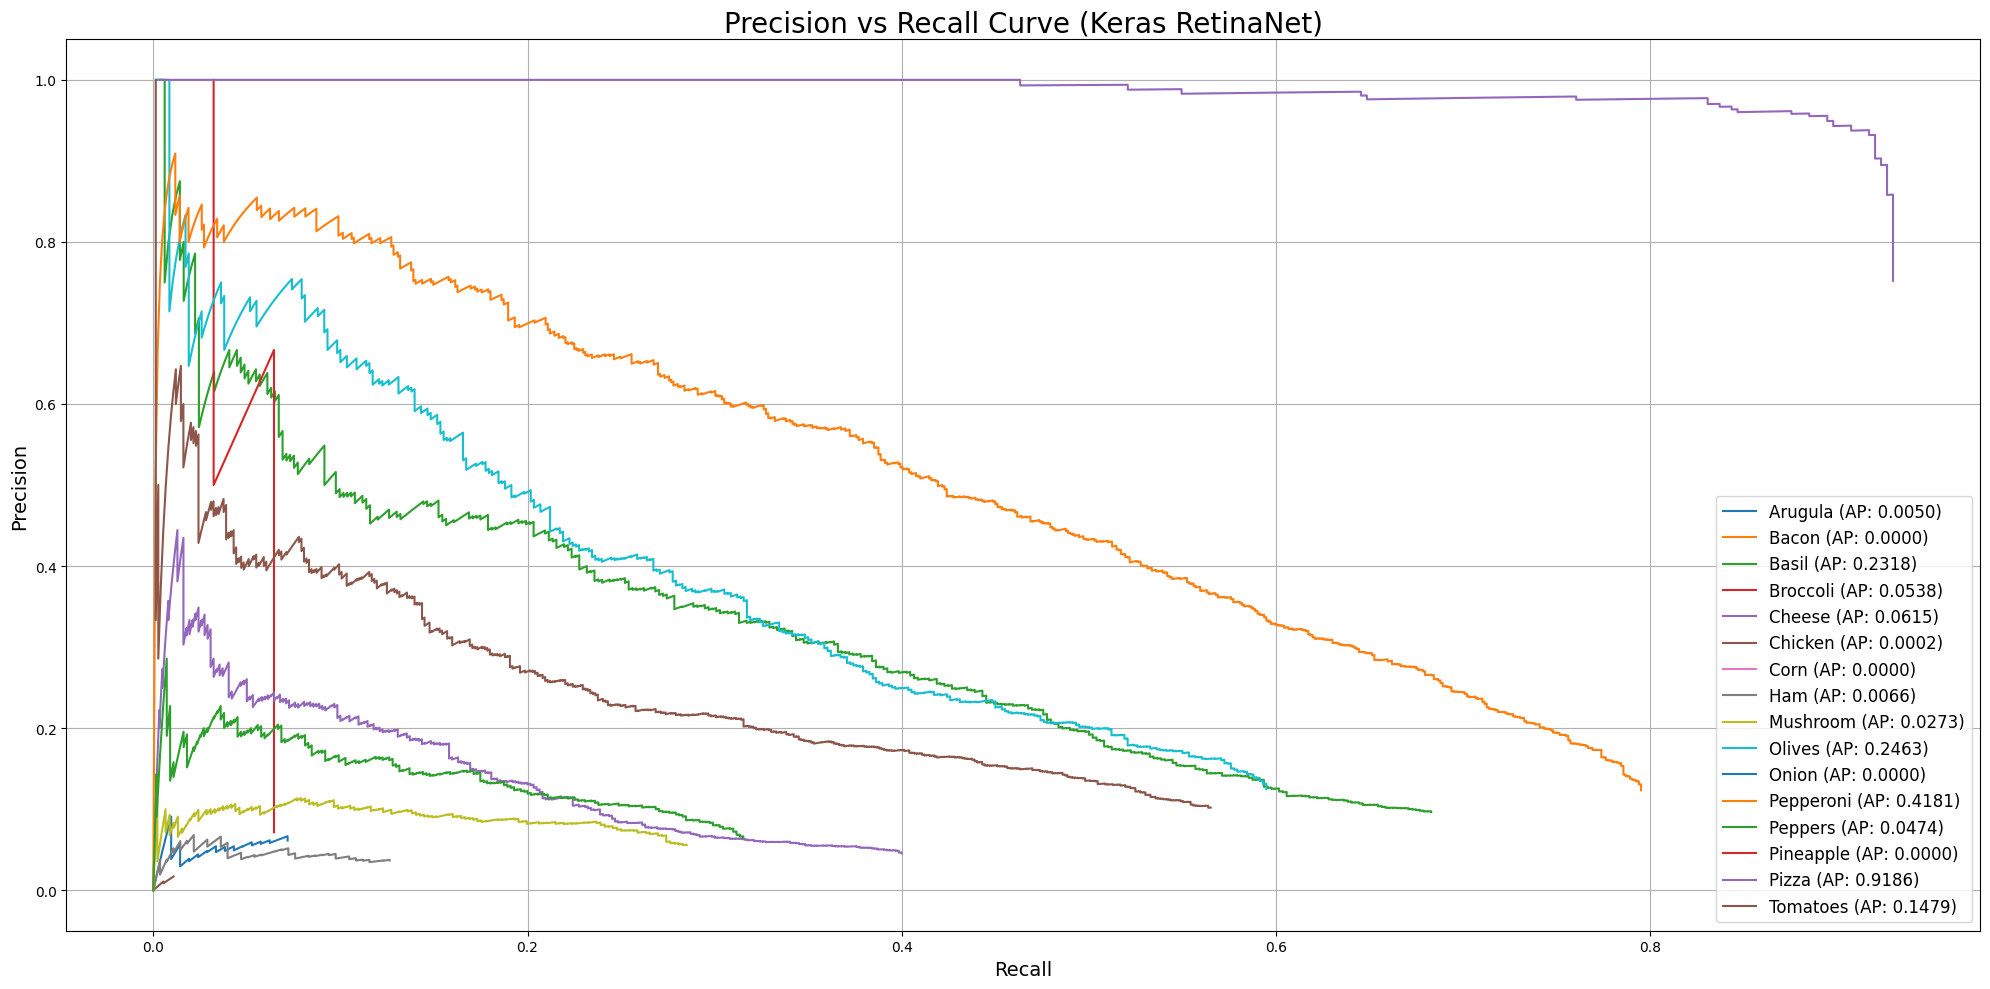

In [31]:
# Plotting precision and recall curve for each class
plt.figure(figsize=(20, 10))
for label, (precision_list, recall_list) in precision_recall.items():
    plt.plot(recall_list, precision_list, label=classes[label] + " (AP: {:.4f})".format(aps[label]))

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision vs Recall Curve (Keras RetinaNet)", fontsize=20)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()
